In [1]:
!pip install jupyterthemes

from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

set_nb_theme('onedork')

# 14-1. 들어가며

<br>

**WIDER FACE 데이터셋**

오늘 Face Detection 모델의 학습을 위해 다루게 될 데이터셋은 바로 [WIDER FACE 데이터셋](http://shuoyang1213.me/WIDERFACE/index.html)입니다. 빠른 인퍼런스 타임을 위해 사용할 YOLO, SSD 같은 single stage model을 학습시키는 것은 흔히 COCO 데이터셋 같은 것이 사용되겠지만, 먼 거리에 흩어져 있는 여러 사람의 얼굴을 빠르게 detect하는 모델을 만들기 위해서는 '보다 넓은 공간에 있는 다수의 사람이 등장하는 이미지 데이터셋'이 보다 적합하겠죠? 아래 그림에서 확인할 수 있듯이 WIDER FACE 데이터셋은 그런 용도로 활용하기에 적절해 보입니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-11-P-00.max-800x600.png)
<center>http://shuoyang1213.me/WIDERFACE</center>

<br>

**준비물**

아래와 같이 작업환경을 준비합시다.
```
$ mkdir -p ~/aiffel/face_detector/assets
$ mkdir -p ~/aiffel/face_detector/dataset
$ mkdir -p ~/aiffel/face_detector/checkpoints
```
<br>

[WIDER FACE 데이터셋 홈페이지](http://shuoyang1213.me/WIDERFACE/index.html)의 4개의 zip파일을 사용할 예정입니다. 사용할 WIDER_xxx.zip 파일들은 아래와 같이 구글드라이브에 올라가 있습니다.

<br>

다만 데이터는 이미 준비되어 있으니 다운로드할 필요는 없습니다.

<br>

- WIDER Face Training Images [Google Drive](https://drive.google.com/file/d/15hGDLhsx8bLgLcIRD5DhYt5iBxnjNF1M/view)
- WIDER Face Validation Images [Google Drive](https://drive.google.com/file/d/1GUCogbp16PMGa39thoMMeWxp7Rp5oM8Q/view)
- WIDER Face Testing Images [Google Drive](https://drive.google.com/file/d/1HIfDbVEWKmsYKJZm4lchTBDLW5N7dY5T/view)
- Face annotations [WIDER FACE 데이터셋 홈페이지](http://shuoyang1213.me/WIDERFACE/index.html)

<br>

준비된 데이터를 연결만 해줍시다.

```
$ ln -s ~/data/* ~/aiffel/face_detector
```
face_detector.zip

<br>

준비된 데이터에는 9개의 python 모듈 파일이 포함되어 있습니다. 확장자가 `py`인 파일들인데요. 위 `face_detector.zip`파일에 들어있는 파일들이니 참고하세요. 이 파일에는 이번 노드의 코드가 모듈 형태로 작성되어 있습니다. python 모듈로 작성된 것과 노드로 작성된 것은 약간 차이가 있지만 핵심 내용은 동일합니다. 학습하는데 참고하세요. 프로젝트에도 도움이 될 수 있습니다.

<br>

이제 준비가 끝났으니 시작해 볼까요?

# 14-2. 데이터셋 전처리(1) 분석

<br>

**WIDER FACE Bounding Box**

오늘 다루게 될 WIDER FACE 데이터셋은 Face detection을 위한 데이터셋이고, 입력데이터는 이미지 파일로, Ground Truth는 Bounding box 정보로 되어 있습니다. 이전 스텝에서 준비한 데이터는 4개의 디렉토리에 들어있습니다.


In [2]:
!cd ~/aiffel/face_detector/widerface && ls wider_face_split  WIDER_test  WIDER_train  WIDER_val

wider_face_split:
readme.txt		      wider_face_train_bbx_gt.txt  wider_face_val.mat
wider_face_test_filelist.txt  wider_face_train.mat
wider_face_test.mat	      wider_face_val_bbx_gt.txt

WIDER_test:
images

WIDER_train:
images

WIDER_val:
images


여기서 `WIDER_xxxx` 로 되어 있는 3개의 디렉토리에는 입력용 이미지 파일만 들어 있습니다. 좀더 구체적으로 분석해 보아야 할 것은 `wider_face_split` 디렉토리 내에 있는 `wider_face_train_bbx_gt.txt`과 `wider_face_val_bbx_gt.txt`, 이 2개 파일 안에 포함되어 있는 Bounding box 정보입니다.

<br>

실제 이 파일들이 어떻게 생겼는지 열어볼까요?

In [3]:
!cd ~/aiffel/face_detector/widerface/wider_face_split && head -20 wider_face_train_bbx_gt.txt

0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
389 281 17 19 2 0 0 0 2 0 
406 293 21 21 2 0 1 0 0 0 


위 명령어의 결과는 아래와 같습니다.
```
0--Parade/0_Parade_marchingband_1_849.jpg
1
449 330 122 149 0 0 0 0 0 0 
0--Parade/0_Parade_Parade_0_904.jpg
1
361 98 263 339 0 0 0 0 0 0 
0--Parade/0_Parade_marchingband_1_799.jpg
21
78 221 7 8 2 0 0 0 0 0 
78 238 14 17 2 0 0 0 0 0 
113 212 11 15 2 0 0 0 0 0 
134 260 15 15 2 0 0 0 0 0 
163 250 14 17 2 0 0 0 0 0 
201 218 10 12 2 0 0 0 0 0 
182 266 15 17 2 0 0 0 0 0 
245 279 18 15 2 0 0 0 0 0 
304 265 16 17 2 0 0 0 2 1 
328 295 16 20 2 0 0 0 0 0 
(이하생략)
```

<br>

텍스트로 이루어진 이 파일 포맷은 다음과 같은 반복 구조로 이루어져 있음을 쉽게 파악할 수 있습니다.
```
# 이미지 파일 경로
0--Parade/0_Parade_marchingband_1_849.jpg
# face bounding box 개수
1
# face bounding box 좌표 등 상세정보
449 330 122 149 0 0 0 0 0 0 
```

<br>

10개의 숫자로 이루어진 face bounding box 좌표 등의 상세정보는 다음과 같은 의미를 가집니다.
```
x0, y0, w, h, blur, expression, illumination, invalid, occlusion, pose
```
bounding box가 관련해서 가장 중요한 4개의 숫자는 **왼쪽의 4개(죄상 꼭짓점의 X 좌표, Y 좌표, 너비, 높이)** 입니다.

<br>

본격적으로 코드를 다루기 전에 필요한 라이브러리와 전역 변수를 준비합니다.

In [4]:
import os, cv2, time
import tensorflow as tf
import tqdm
import numpy as np
import math
from itertools import product
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME')+'/aiffel/face_detector'
DATA_PATH = os.path.join(PROJECT_PATH, 'widerface')
MODEL_PATH = os.path.join(PROJECT_PATH, 'checkpoints')
TRAIN_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'train_mask.tfrecord')
VALID_TFRECORD_PATH = os.path.join(PROJECT_PATH, 'dataset', 'val_mask.tfrecord')
CHECKPOINT_PATH = os.path.join(PROJECT_PATH, 'checkpoints')

DATASET_LEN = 12880
BATCH_SIZE = 32
IMAGE_WIDTH = 320
IMAGE_HEIGHT = 256
IMAGE_LABELS = ['background', 'face']

print(tf.__version__)

2.6.0


먼저 bounding box 파일을 분석해 봅시다. 분석에 필요한 코드를 함수 형태로 준비할게요.

In [5]:
def parse_box(data):
    x0 = int(data[0])
    y0 = int(data[1])
    w = int(data[2])
    h = int(data[3])
    return x0, y0, w, h

print('슝=3')

슝=3


In [6]:
def parse_widerface(file):
    infos = []
    with open(file) as fp:
        line = fp.readline()   # 파일명.readline() : 한 줄씩 읽어 들인다.
        while line:
            n_object = int(fp.readline())
            boxes = []
            for i in range(n_object):
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                if (w == 0) or (h == 0):
                    continue
                boxes.append([x0, y0, w, h])
            if n_object == 0:
                box = fp.readline().split(' ')
                x0, y0, w, h = parse_box(box)
                boxes.append([x0, y0, w, h])
            infos.append((line.strip(), boxes))   # 문자열.strip() : 문자열의 공백 제거
            line = fp.readline()
    return infos

print('슝=3')

슝=3


위 함수는 이미지별 bounding box 정보를 `wider_face_train_bbx_gt.txt`에서 파싱해서 리스트로 추출하는 것입니다.

<br>

이제 추출된 정보를 실제 이미지 정보와 결합합니다. bounding box 정보는 `[x, y, w, h]` 형태로 저장되어 있는데, `[x_min, y_min, x_max, y_max]` 형태의 꼭짓점 좌표 정보로 변환할 거예요.

<br>

이렇게 정보를 결합해야 나중에 학습에 사용하기 좋습니다.

In [7]:
def process_image(image_file):
    image_string = tf.io.read_file(image_file)    # tf.io.read_file(파일명) : 입력 파일 이름의 전체 내용을 읽고 출력한다.
    try:
        image_data = tf.image.decode_jpeg(image_string, channels=3)    # tf.image.decode_jpeg()
        return 0, image_string, image_data
    except tf.errors.InvalidArgumentError:
        return 1, image_string, None

print('슝=3')

슝=3


In [8]:
def xywh_to_voc(file_name, boxes, image_data):
    shape = image_data.shape
    image_info = {}
    image_info['filename'] = file_name
    image_info['width'] = shape[1]
    image_info['height'] = shape[0]
    image_info['depth'] = 3

    difficult = []
    classes = []
    xmin, ymin, xmax, ymax = [], [], [], []

    for box in boxes:
        classes.append(1)
        difficult.append(0)
        xmin.append(box[0])
        ymin.append(box[1])
        xmax.append(box[0] + box[2])
        ymax.append(box[1] + box[3])
    image_info['class'] = classes
    image_info['xmin'] = xmin
    image_info['ymin'] = ymin
    image_info['xmax'] = xmax
    image_info['ymax'] = ymax
    image_info['difficult'] = difficult

    return image_info

print('슝=3')

슝=3


잘 결합된 데이터의 형태를 확인해 봅시다. 5개만 출력해 볼 거예요.

In [9]:
file_path = os.path.join(DATA_PATH, 'wider_face_split', 'wider_face_train_bbx_gt.txt')

for i, info in enumerate(parse_widerface(file_path)):
    print('--------------------')
    image_file = os.path.join(DATA_PATH, 'WIDER_train', 'images', info[0])
    _, image_string, image_data = process_image(image_file)
    boxes = xywh_to_voc(image_file, info[1], image_data)
    print(boxes)
    if i > 3:
        break

--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_849.jpg', 'width': 1024, 'height': 1385, 'depth': 3, 'class': [1], 'xmin': [449], 'ymin': [330], 'xmax': [571], 'ymax': [479], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_Parade_0_904.jpg', 'width': 1024, 'height': 1432, 'depth': 3, 'class': [1], 'xmin': [361], 'ymin': [98], 'xmax': [624], 'ymax': [437], 'difficult': [0]}
--------------------
{'filename': '/aiffel/aiffel/face_detector/widerface/WIDER_train/images/0--Parade/0_Parade_marchingband_1_799.jpg', 'width': 1024, 'height': 768, 'depth': 3, 'class': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'xmin': [78, 78, 113, 134, 163, 201, 182, 245, 304, 328, 389, 406, 436, 522, 643, 653, 793, 535, 29, 3, 20], 'ymin': [221, 238, 212, 260, 250, 218, 266, 279, 265, 295, 281, 293, 290, 328, 320, 224, 337, 311, 22

어떤가요? 이미지별로 `boxes` 리스트에 담긴 bounding box 정보가 확인되시나요? 이제 이 정보를 활용하여 텐서플로우 데이터셋을 생성해 봅시다.

# 14-3. 데이터셋 전처리(2) TFRecord 생성

**TFRecord 만들기**

오늘 다루게 될 대용량 데이터셋의 처리속도 향상을 위해서, 전처리 작업을 통해 TFRecord 데이터셋으로 변환할 필요가 있습니다. TFRecord란 TensorFlow만의 학습 데이터 저장 포맷으로, 이진(binary) 레코드의 시퀀스를 저장합니다. TFRecord 형태의 학습 데이터를 사용하여 모델 학습을 하면 학습 속도가 개선된다는 장점이 있습니다.

<br>

TFRecord는 여러 개의 `tf.train.Example`로 이루어져 있고, 한 개의 `tf.train.Example`은 여러 개의 `tf.train.Feature`로 이루어져 있습니다.

<br>

데이터의 단위를 이루는 `tf.train.Example` 인스턴스를 생성하는 메소드는 아래와 같습니다.



In [10]:
def make_example(image_string, image_infos):
    for info in image_infos:
        filename = info['filename']
        width = info['width']
        height = info['height']
        depth = info['depth']
        classes = info['class']
        xmin = info['xmin']
        ymin = info['ymin']
        xmax = info['xmax']
        ymax = info['ymax']

    if isinstance(image_string, type(tf.constant(0))):   # instance() : 주어진 인스턴스가 특정 클래스/터이터 타입인지 검사 (true/false로 반환)
        encoded_image = [image_string.numpy()]
    else:
        encoded_image = [image_string]

    base_name = [tf.compat.as_bytes(os.path.basename(filename))]
    
    example = tf.train.Example(features=tf.train.Features(feature={
        'filename':tf.train.Feature(bytes_list=tf.train.BytesList(value=base_name)),
        'height':tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'width':tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'classes':tf.train.Feature(int64_list=tf.train.Int64List(value=classes)),
        'x_mins':tf.train.Feature(float_list=tf.train.FloatList(value=xmin)),
        'y_mins':tf.train.Feature(float_list=tf.train.FloatList(value=ymin)),
        'x_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=xmax)),
        'y_maxes':tf.train.Feature(float_list=tf.train.FloatList(value=ymax)),
        'image_raw':tf.train.Feature(bytes_list=tf.train.BytesList(value=encoded_image))
    }))
    
    return example

print('슝=3')

슝=3


이제 전처리를 위해 필요한 함수들이 어느 정도 갖추어졌습니다. 데이터셋의 이미지 파일, 그리고 bounding box 정보를 모아 위의 `make_example` 메소드를 통해 만든 example을 serialize하여 TFRecord 파일로 생성하게 됩니다.

<br>

TFRecord에 대한 자세한 사항은 아래를 참고하세요.

<br>

- [TFRecord](https://www.tensorflow.org/tutorials/load_data/tfrecord)

In [11]:
for split in ['train', 'val']:
    if split == 'train':
        output_file = TRAIN_TFRECORD_PATH 
        anno_txt = 'wider_face_train_bbx_gt.txt'
        file_path = 'WIDER_train'
    else:
        output_file = VALID_TFRECORD_PATH
        anno_txt = 'wider_face_val_bbx_gt.txt'
        file_path = 'WIDER_val'

    with tf.io.TFRecordWriter(output_file) as writer:
        for info in tqdm.tqdm(parse_widerface(os.path.join(DATA_PATH, 'wider_face_split', anno_txt))):
            image_file = os.path.join(DATA_PATH, file_path, 'images', info[0])
            error, image_string, image_data = process_image(image_file)
            boxes = xywh_to_voc(image_file, info[1], image_data)

            if not error:
                tf_example = make_example(image_string, [boxes])
                writer.write(tf_example.SerializeToString())

100%|██████████| 3226/3226 [00:13<00:00, 241.70it/s]


생성된 TFRecord 파일을 확인해 봅시다.

In [12]:
!ls ~/aiffel/face_detector/dataset

train_mask.tfrecord  val_mask.tfrecord


# 14-4. 모델 구현(1) Default boxes

<br>

**SSD의 Default box**

SSD 모델의 가장 중요한 특징 중 하나는 **Default box**를 필요로 한다는 점입니다. 앞서 이야기한 대로 Default box란, object가 존재할 만한 다양한 크기의 box의 좌표 및 클래스 정보를 일정 개수만큼 미리 고정해 둔 것입니다. 흔히 anchor box, prior box라고 부르지요. SSD의 Default box가 약간 다른 점은 여러 층의 feature map에서 box를 만들어 낸다는 점이에요. 층 수 만큼 box 수도 많아지고, 층마다 box의 크기도 다양하게 되죠. ground truth에 해당하는 bounding box와의 IoU를 계산하여 일정 크기(0.5) 이상 겹치는 default box를 선택하는 방식이 RCNN 계열의 sliding window 방식보다 훨씬 속도가 빠르면서도 그와 유사한 정도의 정확도를 얻을 수 있습니다.

<br>

![](https://d3s0tskafalll9.cloudfront.net/media/images/gc-9v3-p-4-1_adjeL1p.max-800x600.jpg)
<center>[Default box]

https://manalelaidouni.github.io/Single%20shot%20object%20detection.html</center>

<br>

이번 프로젝트에서 사용할 default box 정보를 전역 변수로 만들어 둡니다.

In [13]:
BOX_MIN_SIZES = [[10, 16, 24], [32, 48], [64, 96], [128, 192, 256]]
BOX_STEPS = [8, 16, 32, 64]

print('슝=3')

슝=3


![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-11-P-06.max-800x600.png)
<center>[SSD default boxes at 8x8 and 4x4 feature maps]

https://towardsdatascience.com/understanding-ssd-multibox-real-time-object-detection-in-deep-learning-495ef744fab</center>

<br>

위 그림에서 보는 것처럼, default box를 생성하기 위해서는 먼저 기준이 되는 feature map을 먼저 생성합니다. 그림에서는 8 X 8, 4 X 4의 예가 나오지만, 우리의 프로젝트에서는 아래와 같이 4가지 유형의 feature map을 생성하게 됩니다.

In [14]:
image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
min_sizes = BOX_MIN_SIZES
steps= BOX_STEPS

feature_maps = [
    [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
    for step in steps
]

feature_maps

[[32, 40], [16, 20], [8, 10], [4, 5]]

[[32, 40], [16, 20], [8, 10], [4, 5]]
이제 feature map별로 순회를 하면서 default box 를 생성해 보겠습니다.

In [15]:
boxes = []

for k, f in enumerate(feature_maps):
    for i, j in product(range(f[0]), range(f[1])):
        for min_size in min_sizes[k]:
            s_kx = min_size / image_sizes[1]
            s_ky = min_size / image_sizes[0]
            cx = (j + 0.5) * steps[k] / image_sizes[1]
            cy = (i + 0.5) * steps[k] / image_sizes[0]
            boxes += [cx, cy, s_kx, s_ky]

len(boxes)

18800

생성된 `boxes`에는 default box 정보가 구분없이 나열되어 있으므로 4개씩 재배열 시켜줄게요.

In [16]:
pretty_boxes = np.asarray(boxes).reshape([-1, 4])
print(pretty_boxes.shape)
print(pretty_boxes)

(4700, 4)
[[0.0125    0.015625  0.03125   0.0390625]
 [0.0125    0.015625  0.05      0.0625   ]
 [0.0125    0.015625  0.075     0.09375  ]
 ...
 [0.9       0.875     0.4       0.5      ]
 [0.9       0.875     0.6       0.75     ]
 [0.9       0.875     0.8       1.       ]]


모두 4700개의 default box가 만들어 졌네요. `feature_maps`와 `min_sizes`로부터 40x32x3 + 20x16x2 + 10x8x2 + 5x4x3 개가 생성되었다는 걸 확인할 수 있습니다.

<br>

지금까지 만들었던, feature map을 만들고 그에 연결된 default box를 생성하는 코드를 사용하기 편리하도록 함수로 정의해 둡시다.

In [17]:
def default_box():
    image_sizes = (IMAGE_HEIGHT, IMAGE_WIDTH)
    min_sizes = BOX_MIN_SIZES
    steps= BOX_STEPS
    feature_maps = [
        [math.ceil(image_sizes[0] / step), math.ceil(image_sizes[1] / step)]
        for step in steps
    ]
    boxes = []
    for k, f in enumerate(feature_maps):
        for i, j in product(range(f[0]), range(f[1])):
            for min_size in min_sizes[k]:
                s_kx = min_size / image_sizes[1]
                s_ky = min_size / image_sizes[0]
                cx = (j + 0.5) * steps[k] / image_sizes[1]
                cy = (i + 0.5) * steps[k] / image_sizes[0]
                boxes += [cx, cy, s_kx, s_ky]
    boxes = np.asarray(boxes).reshape([-1, 4])
    return boxes

print('슝=3')

슝=3


# 14-5. 모델 구현(2) SSD

**SSD model 빌드하기**

<br>

그럼 본격적으로 SSD 모델을 생성해 보겠습니다. 우선은 SSD 모델 내부에서 사용하는 레이어들을 아래와 같이 생성합니다.

일반적으로 많이 쓰이는 **Convolution 블록, Depthwise Convolution 블록**, 그리고 skip connection으로 쓰일 **Branch 블록**을 준비합니다.

In [18]:
def _conv_block(inputs, filters, kernel=(3, 3), strides=(1, 1)):
    block_id = (tf.keras.backend.get_uid())
    if strides == (2, 2):
        x = tf.keras.layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='valid',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(x)
    else:
        x = tf.keras.layers.Conv2D(filters, kernel,
                                   padding='same',
                                   use_bias=False,
                                   strides=strides,
                                   name='conv_%d' % block_id)(inputs)
    
    x = tf.keras.layers.BatchNormalization(name='conv_bn_%d' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_relu_%d' % block_id)(x)

print('슝=3')

슝=3


In [19]:
def _depthwise_conv_block(inputs, filters, strides=(1, 1)):
    block_id = tf.keras.backend.get_uid()
    if strides == (1, 1):
        x = inputs
    else:
        x = tf.keras.layers.ZeroPadding2D(((1, 1), (1, 1)), name='conv_pad_%d' % block_id)(inputs)
    x = tf.keras.layers.DepthwiseConv2D((3, 3),
                                        padding='same' if strides == (1, 1) else 'valid',
                                        strides=strides,
                                        use_bias=False,
                                        name='conv_dw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_dw_%d_bn' % block_id)(x)
    x = tf.keras.layers.ReLU(name='conv_dw_%d_relu' % block_id)(x)
    x = tf.keras.layers.Conv2D(filters, (1, 1),
                               padding='same',
                               use_bias=False,
                               strides=(1, 1),
                               name='conv_pw_%d' % block_id)(x)
    x = tf.keras.layers.BatchNormalization(name='conv_pw_%d_bn' % block_id)(x)
    return tf.keras.layers.ReLU(name='conv_pw_%d_relu' % block_id)(x)

print('슝=3')

슝=3


In [20]:
def _branch_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), padding='same')(x)
    x1 = tf.keras.layers.Conv2D(filters * 2, kernel_size=(3, 3), padding='same')(inputs)
    x = tf.keras.layers.Concatenate(axis=-1)([x, x1])
    return tf.keras.layers.ReLU()(x)

print('슝=3')

슝=3


여러 블록을 쌓아 모델을 만든 후, 중간중간 Branch 부분에 **헤드(head)** 라고 불리는 Convolution 레이어를 붙일 거예요. **하나의 헤드에 Convolution 레이어 두 개**가 필요합니다. 하나는 **confidence를 예측**하기 위해 사용하고 다른 하나는 **location을 예측**하기 위해 사용해요.

<br>

Branch마다 헤드가 연결되어 있기 때문에 모델의 중간 레이어에서도 예측을 위한 정보를 가져올 수 있게 되었습니다.

In [21]:
def _create_head_block(inputs, filters):
    x = tf.keras.layers.Conv2D(filters, kernel_size=(3, 3), strides=(1, 1), padding='same')(inputs)
    return x

print('슝=3')

슝=3


In [22]:
def _compute_heads(inputs, num_class, num_cell):
    conf = _create_head_block(inputs, num_cell * num_class)
    conf = tf.keras.layers.Reshape((-1, num_class))(conf)
    loc = _create_head_block(inputs, num_cell * 4)
    loc = tf.keras.layers.Reshape((-1, 4))(loc)
    return conf, loc

print('슝=3')

슝=3


레이어들이 준비되었습니다. 이제 본격적으로 SSD model을 준비해 보겠습니다.

In [23]:
def SsdModel():
    base_channel = 16
    num_cells = [3, 2, 2, 3]
    num_class = len(IMAGE_LABELS)
    
    x = inputs = tf.keras.layers.Input(shape=[IMAGE_HEIGHT, IMAGE_WIDTH, 3], name='input_image')

    x = _conv_block(x, base_channel, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 2, strides=(2, 2))
    x = _conv_block(x, base_channel * 2, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(2, 2))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x = _conv_block(x, base_channel * 4, strides=(1, 1))
    x1 = _branch_block(x, base_channel)

    x = _conv_block(x, base_channel * 8, strides=(2, 2))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x = _conv_block(x, base_channel * 8, strides=(1, 1))
    x2 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x = _depthwise_conv_block(x, base_channel * 16, strides=(1, 1))
    x3 = _branch_block(x, base_channel)

    x = _depthwise_conv_block(x, base_channel * 16, strides=(2, 2))
    x4 = _branch_block(x, base_channel)

    extra_layers = [x1, x2, x3, x4]

    confs = []
    locs = []

    for layer, num_cell in zip(extra_layers, num_cells):
        conf, loc = _compute_heads(layer, num_class, num_cell)
        confs.append(conf)
        locs.append(loc)

    confs = tf.keras.layers.Concatenate(axis=1, name="face_classes")(confs)
    locs = tf.keras.layers.Concatenate(axis=1, name="face_boxes")(locs)

    predictions = tf.keras.layers.Concatenate(axis=2, name='predictions')([locs, confs])

    model = tf.keras.Model(inputs=inputs, outputs=predictions, name='ssd_model')
    return model

print('슝=3')

슝=3


준비한 모델을 생성해 봅시다.

In [24]:
model = SsdModel()
print("the number of model layers: ", len(model.layers))
model.summary()

the number of model layers:  101
Model: "ssd_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 320, 3) 0                                            
__________________________________________________________________________________________________
conv_pad_1 (ZeroPadding2D)      (None, 258, 322, 3)  0           input_image[0][0]                
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 160, 16) 432         conv_pad_1[0][0]                 
__________________________________________________________________________________________________
conv_bn_1 (BatchNormalization)  (None, 128, 160, 16) 64          conv_1[0][0]                     
_________________________________________________________

101층의 SSD 모델이 완성되었습니다!

# 14-6. 모델 학습(1) Augmentation, jaccard 적용

**Augmentation**

이전 스텝에서 모델까지 구현하였습니다. 그러나 본격적으로 학습을 진행하기 전에 아직 해야할 것이 몇 가지 더 남아있습니다.

<br>

이전 스텝에서 구성한 TFRecord 형태의 데이터셋은 아직 Data augmentation이 적용되지 않았습니다. Object detection에서 사용하는 다양한 augmentation 기법을 적용해 주면 성능이 조금 더 향상될 수도 있습니다.

<br>

아래는 augmentation을 위해 `tf.data.TFRecordDataset.map()` 내에서 호출할 메소드들입니다.

<br>

- `_crop`
- `_pad_to_square`
- `_resize`
- `_flip`
- `_distort`

<br>

Image Classification에서 사용하던 함수와는 비교가 안 될 정도로 복잡한 함수들입니다. 이미지가 변경되면서 box의 위치나 크기도 함께 변경되어야 하기 때문에 함수가 복잡해질 수 밖에 없어요.

<br>

이미지를 `_crop`했을 때 box도 함께 잘릴 수가 있어요. 함께 신경써서 잘라줍니다.

In [25]:
def _crop(img, labels, max_loop=250):
    shape = tf.shape(img)

    def matrix_iof(a, b):
        lt = tf.math.maximum(a[:, tf.newaxis, :2], b[:, :2])
        rb = tf.math.minimum(a[:, tf.newaxis, 2:], b[:, 2:])

        area_i = tf.math.reduce_prod(rb - lt, axis=2) * \
            tf.cast(tf.reduce_all(lt < rb, axis=2), tf.float32)
        area_a = tf.math.reduce_prod(a[:, 2:] - a[:, :2], axis=1)
        return area_i / tf.math.maximum(area_a[:, tf.newaxis], 1)

    def crop_loop_body(i, img, labels):
        valid_crop = tf.constant(1, tf.int32)

        pre_scale = tf.constant([0.3, 0.45, 0.6, 0.8, 1.0], dtype=tf.float32)
        scale = pre_scale[tf.random.uniform([], 0, 5, dtype=tf.int32)]
        short_side = tf.cast(tf.minimum(shape[0], shape[1]), tf.float32)
        h = w = tf.cast(scale * short_side, tf.int32)
        h_offset = tf.random.uniform([], 0, shape[0] - h + 1, dtype=tf.int32)
        w_offset = tf.random.uniform([], 0, shape[1] - w + 1, dtype=tf.int32)
        roi = tf.stack([w_offset, h_offset, w_offset + w, h_offset + h])
        roi = tf.cast(roi, tf.float32)

        value = matrix_iof(labels[:, :4], roi[tf.newaxis])
        valid_crop = tf.cond(tf.math.reduce_any(value >= 1),
                             lambda: valid_crop, lambda: 0)

        centers = (labels[:, :2] + labels[:, 2:4]) / 2
        mask_a = tf.reduce_all(
            tf.math.logical_and(roi[:2] < centers, centers < roi[2:]),
            axis=1)
        labels_t = tf.boolean_mask(labels, mask_a)
        valid_crop = tf.cond(tf.reduce_any(mask_a),
                             lambda: valid_crop, lambda: 0)

        img_t = img[h_offset:h_offset + h, w_offset:w_offset + w, :]
        h_offset = tf.cast(h_offset, tf.float32)
        w_offset = tf.cast(w_offset, tf.float32)
        labels_t = tf.stack(
            [labels_t[:, 0] - w_offset,  labels_t[:, 1] - h_offset,
             labels_t[:, 2] - w_offset,  labels_t[:, 3] - h_offset,
             labels_t[:, 4]], axis=1)

        return tf.cond(valid_crop == 1,
                       lambda: (max_loop, img_t, labels_t),
                       lambda: (i + 1, img, labels))

    _, img, labels = tf.while_loop(
        lambda i, img, labels: tf.less(i, max_loop),
        crop_loop_body,
        [tf.constant(-1), img, labels],
        shape_invariants=[tf.TensorShape([]),
                          tf.TensorShape([None, None, 3]),
                          tf.TensorShape([None, 5])])

    return img, labels

print('슝=3')

슝=3


`_resize`나 `_flip`도 box에 영향을 끼칩니다.

In [26]:
def _resize(img, labels):
    w_f = tf.cast(tf.shape(img)[1], tf.float32)
    h_f = tf.cast(tf.shape(img)[0], tf.float32)
    locs = tf.stack([labels[:, 0] / w_f,  labels[:, 1] / h_f,
                     labels[:, 2] / w_f,  labels[:, 3] / h_f] ,axis=1)
    locs = tf.clip_by_value(locs, 0, 1.0)
    labels = tf.concat([locs, labels[:, 4][:, tf.newaxis]], axis=1)

    resize_case = tf.random.uniform([], 0, 5, dtype=tf.int32)

    def resize(method):
        def _resize():
            #　size h,w
            return tf.image.resize(img, [IMAGE_HEIGHT, IMAGE_WIDTH], method=method, antialias=True)
        return _resize

    img = tf.case([(tf.equal(resize_case, 0), resize('bicubic')),
                   (tf.equal(resize_case, 1), resize('area')),
                   (tf.equal(resize_case, 2), resize('nearest')),
                   (tf.equal(resize_case, 3), resize('lanczos3'))],
                  default=resize('bilinear'))

    return img, labels

print('슝=3')

슝=3


In [27]:
def _flip(img, labels):
    flip_case = tf.random.uniform([], 0, 2, dtype=tf.int32)

    def flip_func():
        flip_img = tf.image.flip_left_right(img)
        flip_labels = tf.stack([1 - labels[:, 2],  labels[:, 1],
                                1 - labels[:, 0],  labels[:, 3],
                                labels[:, 4]], axis=1)

        return flip_img, flip_labels

    img, labels = tf.case([(tf.equal(flip_case, 0), flip_func)],default=lambda: (img, labels))

    return img, labels

print('슝=3')

슝=3


`_pad_to_square`는 이미지가 정사각형이 되도록 이미지 오른쪽이나 아래 방향으로 평균 색상 영역을 추가해주는 작업입니다.

<br>

다행히도 이미지 왼쪽이나 위쪽으로는 변화가 없기 때문에 box 정보는 변하지 않습니다.

In [28]:
def _pad_to_square(img):
    height = tf.shape(img)[0]
    width = tf.shape(img)[1]

    def pad_h():
        img_pad_h = tf.ones([width - height, width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_h], axis=0)

    def pad_w():
        img_pad_w = tf.ones([height, height - width, 3]) * tf.reduce_mean(img, axis=[0, 1], keepdims=True)
        return tf.concat([img, img_pad_w], axis=1)

    img = tf.case([(tf.greater(height, width), pad_w),
                   (tf.less(height, width), pad_h)], default=lambda: img)
    return img

print('슝=3')

슝=3


이미지 색상 값만 바꿔주는 `_distort`에서도 box 정보를 바꿀 필요는 없겠네요!

In [29]:
def _distort(img):
    img = tf.image.random_brightness(img, 0.4)
    img = tf.image.random_contrast(img, 0.5, 1.5)
    img = tf.image.random_saturation(img, 0.5, 1.5)
    img = tf.image.random_hue(img, 0.1)

    return img

print('슝=3')

슝=3


## Default box 적용

SSD 모델의 특이점 중 하나가 default box를 사용한다는 점을 이미 앞에서 설명하였습니다. default box 정보는 데이터셋에 반영되어야 합니다. 아래 메소드들은 default box와 bounding box 사이의 IoU, 다른 말로 자카드 유사도(자카드 지수, jaccard index)를 측정하기 위한 것입니다.

<br>

**자카드 유사도**는 두 집합을 통해 **유사도를 측정**하는 방식 중 하나로, 두 집합의 교집합을 두 집합의 합집합으로 나눕니다. 따라서 자카드 유사도는 0과 1 사이의 값을 가지며, 두 집합의 합집합과 교집합이 서로 비슷하면 1에 근접하다는 뜻입니다.

<br>

자카드 유사도의 공식은 아래와 같습니다.

<br>

- 자카드 유사도

$$J(X, Y)=\frac{|X \cap Y|}{|X U Y|}=\frac{|X \cap Y|}{|X|+|Y|-|X \cap Y|} \quad, 0 \leq J(X, Y) \leq 1$$

<br>

이제 이 메소드를 활용해 어떻게 데이터셋을 추가로 가공하는지 살펴봅시다.

In [30]:
def _intersect(box_a, box_b):
    A = tf.shape(box_a)[0]
    B = tf.shape(box_b)[0]
    max_xy = tf.minimum(
        tf.broadcast_to(tf.expand_dims(box_a[:, 2:], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, 2:], 0), [A, B, 2]))
    min_xy = tf.maximum(
        tf.broadcast_to(tf.expand_dims(box_a[:, :2], 1), [A, B, 2]),
        tf.broadcast_to(tf.expand_dims(box_b[:, :2], 0), [A, B, 2]))
    inter = tf.clip_by_value(max_xy - min_xy, 0.0, 512.0)
    return inter[:, :, 0] * inter[:, :, 1]

print('슝=3')

슝=3


In [31]:
def _jaccard(box_a, box_b):
    inter = _intersect(box_a, box_b)
    area_a = tf.broadcast_to(
        tf.expand_dims(
            (box_a[:, 2] - box_a[:, 0]) * (box_a[:, 3] - box_a[:, 1]), 1),
        tf.shape(inter))  # [A,B]
    area_b = tf.broadcast_to(
        tf.expand_dims(
            (box_b[:, 2] - box_b[:, 0]) * (box_b[:, 3] - box_b[:, 1]), 0),
        tf.shape(inter))  # [A,B]
    union = area_a + area_b - inter
    return inter / union  # [A,B]

print('슝=3')

슝=3


자카드 유사도를 계산하는 메소드가 준비되었습니다. 아래 `encode_tf`는 이를 이용해서 TFRecord 데이터셋의 라벨을 가공하는 메소드입니다. 내용을 정리하면 다음과 같습니다.

<br>

- jaccard 메소드를 이용해 label의 ground truth bbox와 가장 overlap 비율이 높은 matched box를 구한다.
- `_encode_bbox` 메소드를 통해 bbox의 scale을 동일하게 보정한다.
- 전체 default box에 대해 일정 threshold 이상 overlap되는 ground truth bounding box 존재 여부(positive/negative)를 concat하여 새로운 label로 업데이트한다.

In [32]:
def _encode_bbox(matched, boxes, variances=[0.1, 0.2]):
    g_cxcy = (matched[:, :2] + matched[:, 2:]) / 2 - boxes[:, :2]
    g_cxcy /= (variances[0] * boxes[:, 2:])
    g_wh = (matched[:, 2:] - matched[:, :2]) / boxes[:, 2:]
    g_wh = tf.math.log(g_wh) / variances[1]
    g_wh = tf.where(tf.math.is_inf(g_wh), 0.0, g_wh)
    return tf.concat([g_cxcy, g_wh], 1)

print('슝=3')

슝=3


In [33]:
def encode_tf(labels, boxes):
    match_threshold = 0.45
    boxes = tf.cast(boxes, tf.float32)
    bbox = labels[:, :4]
    conf = labels[:, -1]
   
    # jaccard index
    overlaps = _jaccard(bbox, boxes)
    best_box_overlap = tf.reduce_max(overlaps, 1)
    best_box_idx = tf.argmax(overlaps, 1, tf.int32)

    best_truth_overlap = tf.reduce_max(overlaps, 0)
    best_truth_idx = tf.argmax(overlaps, 0, tf.int32)

    best_truth_overlap = tf.tensor_scatter_nd_update(
        best_truth_overlap, tf.expand_dims(best_box_idx, 1),
        tf.ones_like(best_box_idx, tf.float32) * 2.)
    best_truth_idx = tf.tensor_scatter_nd_update(
        best_truth_idx, tf.expand_dims(best_box_idx, 1),
        tf.range(tf.size(best_box_idx), dtype=tf.int32))
    # Scale Ground-Truth Boxes   
    matches_bbox = tf.gather(bbox, best_truth_idx)
    loc_t = _encode_bbox(matches_bbox, boxes)
    conf_t = tf.gather(conf, best_truth_idx)
    conf_t = tf.where(tf.less(best_truth_overlap, match_threshold), tf.zeros_like(conf_t), conf_t)

    return tf.concat([loc_t, conf_t[..., tf.newaxis]], axis=1)

print('슝=3')

슝=3


## load_dataset

위에서 구현한 두가지 메소드를 이전 스텝에서 생성한 tfrecord 데이터셋에 적용하여 SSD 학습을 위한 데이터셋을 생성하는 최종 메소드인 load_dataset 을 구현합니다.

<br>

- `_transform_data` : augmemtation과 label을 encoding 하여 기존의 dataset을 변환하는 메소드
- `_parse_tfrecord` : TFRecord 에 `_transform_data`를 적용하는 함수 클로저 생성
- `load_tfrecord_dataset` : `tf.data.TFRecordDataset.map()`에 `_parse_tfrecord`을 적용하는 실제 데이터셋 변환 메인 메소드
- `load_dataset` : `load_tfrecord_dataset`을 통해 train, validation 데이터셋을 생성하는 최종 메소드

In [34]:
def _transform_data(train, boxes):
    def transform_data(img, labels):
        img = tf.cast(img, tf.float32)
        if train:
            img, labels = _crop(img, labels)
            img = _pad_to_square(img)

        img, labels = _resize(img, labels)

        if train:
            img, labels = _flip(img, labels)

        if train:
            img = _distort(img)
        labels = encode_tf(labels, boxes)        
        img = img/255.0
        return img, labels
    return transform_data

print('슝=3')

슝=3


In [35]:
def _parse_tfrecord(train, boxes):
    def parse_tfrecord(tfrecord):
        features = {
            'filename': tf.io.FixedLenFeature([], tf.string),
            'height': tf.io.FixedLenFeature([], tf.int64),
            'width': tf.io.FixedLenFeature([], tf.int64),
            'classes': tf.io.VarLenFeature(tf.int64),
            'x_mins': tf.io.VarLenFeature(tf.float32),
            'y_mins': tf.io.VarLenFeature(tf.float32),
            'x_maxes': tf.io.VarLenFeature(tf.float32),
            'y_maxes': tf.io.VarLenFeature(tf.float32),
            'difficult':tf.io.VarLenFeature(tf.int64),
            'image_raw': tf.io.FixedLenFeature([], tf.string),
           }

        parsed_example = tf.io.parse_single_example(tfrecord, features)
        img = tf.image.decode_jpeg(parsed_example['image_raw'], channels=3)

        width = tf.cast(parsed_example['width'], tf.float32)
        height = tf.cast(parsed_example['height'], tf.float32)

        labels = tf.sparse.to_dense(parsed_example['classes'])
        labels = tf.cast(labels, tf.float32)

        labels = tf.stack(
            [tf.sparse.to_dense(parsed_example['x_mins']),
             tf.sparse.to_dense(parsed_example['y_mins']),
             tf.sparse.to_dense(parsed_example['x_maxes']),
             tf.sparse.to_dense(parsed_example['y_maxes']),labels], axis=1)

        img, labels = _transform_data(train, boxes)(img, labels)

        return img, labels
    return parse_tfrecord

print('슝=3')

슝=3


In [36]:
def load_tfrecord_dataset(tfrecord_name, train=True, boxes=None, buffer_size=1024):
    raw_dataset = tf.data.TFRecordDataset(tfrecord_name)
    raw_dataset = raw_dataset.cache()
    if train:
        raw_dataset = raw_dataset.repeat()
        raw_dataset = raw_dataset.shuffle(buffer_size=buffer_size)

    dataset = raw_dataset.map(_parse_tfrecord(train, boxes), num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

print('슝=3')

슝=3


In [37]:
def load_dataset(boxes, train=True, buffer_size=1024):
    if train:
        dataset = load_tfrecord_dataset(
            tfrecord_name=TRAIN_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    else:
        dataset = load_tfrecord_dataset(
            tfrecord_name=VALID_TFRECORD_PATH,
            train=train,
            boxes=boxes,
            buffer_size=buffer_size)
    return dataset

print('슝=3')

슝=3


상당히 긴 데이터 준비 과정이 끝났습니다.

# 14-7. 모델 학습(2) train


## Learning rate scheduler

본격적으로 train에 들어가기 전에 2가지 더 준비해야 할 게 있습니다. 그중 하나는 Learning rate scheduler 입니다. 이번에는 초기시점에 WarmUp부분을 도입해 learning rate가 천천히 증가할 수 있도록 학습 스텝에 따라 다른 Learning Rate이 적용될 수 있도록 하겠습니다. `PiecewiseConstantWarmUpDecay`정도의 이름으로 만들어 사용할게요.

In [38]:
class PiecewiseConstantWarmUpDecay(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, boundaries, values, warmup_steps, min_lr, name=None):
        super(PiecewiseConstantWarmUpDecay, self).__init__()

        if len(boundaries) != len(values) - 1:
            raise ValueError(
                    "The length of boundaries should be 1 less than the"
                    "length of values")

        self.boundaries = boundaries
        self.values = values
        self.name = name
        self.warmup_steps = warmup_steps
        self.min_lr = min_lr

    def __call__(self, step):
        with tf.name_scope(self.name or "PiecewiseConstantWarmUp"):
            step = tf.cast(tf.convert_to_tensor(step), tf.float32)
            pred_fn_pairs = []
            warmup_steps = self.warmup_steps
            boundaries = self.boundaries
            values = self.values
            min_lr = self.min_lr

            pred_fn_pairs.append(
                (step <= warmup_steps,
                 lambda: min_lr + step * (values[0] - min_lr) / warmup_steps))
            pred_fn_pairs.append(
                (tf.logical_and(step <= boundaries[0],
                                step > warmup_steps),
                 lambda: tf.constant(values[0])))
            pred_fn_pairs.append(
                (step > boundaries[-1], lambda: tf.constant(values[-1])))

            for low, high, v in zip(boundaries[:-1], boundaries[1:],
                                    values[1:-1]):
                pred = (step > low) & (step <= high)
                pred_fn_pairs.append((pred, lambda: tf.constant(v)))

            return tf.case(pred_fn_pairs, lambda: tf.constant(values[0]),
                           exclusive=True)

print('슝=3')

슝=3


`PiecewiseConstantWarmUpDecay`를 편하게 사용할 수 있도록 함수를 만들어 둡니다.

In [39]:
def MultiStepWarmUpLR(initial_learning_rate, lr_steps, lr_rate,
                      warmup_steps=0., min_lr=0.,
                      name='MultiStepWarmUpLR'):
    assert warmup_steps <= lr_steps[0]
    assert min_lr <= initial_learning_rate
    lr_steps_value = [initial_learning_rate]
    for _ in range(len(lr_steps)):
        lr_steps_value.append(lr_steps_value[-1] * lr_rate)
    return PiecewiseConstantWarmUpDecay(
        boundaries=lr_steps, values=lr_steps_value, warmup_steps=warmup_steps,
        min_lr=min_lr)

print('슝=3')

슝=3


## Hard negative mining

Object Detection 모델 학습시 자주 사용되는 Hard negative mining이라는 기법이 있습니다. 학습과정에서 label은 negative인데 confidence가 높게 나오는 샘플을 재학습하면 positive와 negative의 모호한 경계선상에 분포한 false negative 오류에 강해진다는 장점이 있습니다. 실제로 confidence가 높은 샘플을 모아 training을 다시 수행하기보다는, 그런 샘플들에 대한 loss만 따로 모아 계산해주는 방식으로 반영할 수 있습니다.

<br>

Object Detection에서는 물체 영역보다 배경 영역이 훨씬 많기 십상이므로 negative 비율을 positive의 3배가 되도록 설정해 주었습니다.

<br>

아래 구현된 `hard_negative_mining` 메소드와, 이 메소드를 통해 얻은 샘플을 통해 얻은 localization loss를 기존의 classification loss에 추가로 반영하는 `MultiBoxLoss` 계산 메소드를 확인해 주세요.

In [40]:
def hard_negative_mining(loss, class_truth, neg_ratio):
    pos_idx = class_truth > 0
    num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.int32), axis=1)
    num_neg = num_pos * neg_ratio

    rank = tf.argsort(loss, axis=1, direction='DESCENDING')
    rank = tf.argsort(rank, axis=1)
    neg_idx = rank < tf.expand_dims(num_neg, 1)

    return pos_idx, neg_idx

print('슝=3')

슝=3


In [41]:
def MultiBoxLoss(num_class, neg_pos_ratio=3.0):
    def multi_loss(y_true, y_pred):
        num_batch = tf.shape(y_true)[0]
        loc_pred, class_pred = y_pred[..., :4], y_pred[..., 4:]
        loc_truth, class_truth = y_true[..., :4], tf.squeeze(y_true[..., 4:])

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')
        temp_loss = cross_entropy(class_truth, class_pred)
        pos_idx, neg_idx = hard_negative_mining(temp_loss, class_truth, neg_pos_ratio)

        cross_entropy = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum')
        loss_class = cross_entropy(
            class_truth[tf.math.logical_or(pos_idx, neg_idx)],
            class_pred[tf.math.logical_or(pos_idx, neg_idx)])
        
        smooth_l1_loss = tf.keras.losses.Huber(reduction='sum')
        loss_loc = smooth_l1_loss(loc_truth[pos_idx],loc_pred[pos_idx])

        num_pos = tf.math.reduce_sum(tf.cast(pos_idx, tf.float32))

        loss_class = loss_class / num_pos
        loss_loc = loss_loc / num_pos
        return loss_loc, loss_class

    return multi_loss

print('슝=3')

슝=3


## Training

이제 본격적으로 모델 학습을 진행하겠습니다.

Default box를 만들고 데이터셋을 준비합니다.

In [42]:
boxes = default_box()
train_dataset = load_dataset(boxes, train=True)

print('슝=3')

슝=3


나머지 학습에 필요한 요소들도 생성해 줍니다.

In [43]:
steps_per_epoch = DATASET_LEN // BATCH_SIZE
learning_rate = MultiStepWarmUpLR(
    initial_learning_rate=1e-2,
    lr_steps=[e*steps_per_epoch for e in [50, 70]],
    lr_rate=0.1,
    warmup_steps=5*steps_per_epoch,
    min_lr=1e-4
)
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)

multi_loss = MultiBoxLoss(len(IMAGE_LABELS), neg_pos_ratio=3)

print('슝=3')

슝=3


이제 학습이 진행될 함수를 작성할 차례입니다. `tf.GradientTape()`을 사용하는 방식에 익숙해 지셨나요? 아직 어렵다면 아래 링크를 참고하세요!

<br>

- [GradientTape](https://www.tensorflow.org/api_docs/python/tf/GradientTape)
- [Writing a training loop from scratch](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)

<br>

한 스텝이 학습되는 함수를 아래처럼 작성합니다.

In [44]:
@tf.function
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        losses = {}
        losses['reg'] = tf.reduce_sum(model.losses)  #unused. Init for redefine network
        losses['loc'], losses['class'] = multi_loss(labels, predictions)
        total_loss = tf.add_n([l for l in losses.values()])

    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return total_loss, losses

print('슝=3')

슝=3


아래에서 본격적으로 train을 시작합니다. 100 epochs 이상 학습시켜야 좋은 성능을 보이지만 1 epoch 만 학습해 확인해 봅시다.

In [56]:
EPOCHS = 70

for epoch in range(0, EPOCHS):
    for step, (inputs, labels) in enumerate(train_dataset.take(steps_per_epoch)):
        load_t0 = time.time()
        total_loss, losses = train_step(inputs, labels)
        load_t1 = time.time()
        batch_time = load_t1 - load_t0
        print(f"\rEpoch: {epoch + 1}/{EPOCHS} | Batch {step + 1}/{steps_per_epoch} | Batch time {batch_time:.3f} || Loss: {total_loss:.6f} | loc loss:{losses['loc']:.6f} | class loss:{losses['class']:.6f} ",end = '',flush=True)

    filepath = os.path.join(CHECKPOINT_PATH, f'weights_epoch_{(epoch + 1):03d}.h5')
    model.save_weights(filepath)

Epoch: 70/70 | Batch 402/402 | Batch time 0.058 || Loss: 6.856836 | loc loss:5.767005 | class loss:1.089831  

# 14-8. inference(1) NMS

**NMS 구현하기**

Grid cell을 사용하는 Object detection의 inference 단계에서 하나의 object가 여러 개의 default box에 걸쳐져 있을 때 IoU가 가장 높은 default box를 선택하는 NMS(non-max suppression)이 필요합니다. 아래 코드를 확인해 주세요.

In [46]:
def compute_nms(boxes, scores, nms_threshold=0.4, limit=200):
    if boxes.shape[0] == 0:
        return tf.constant([], dtype=tf.int32)
    selected = [0]
    idx = tf.argsort(scores, direction='DESCENDING')
    idx = idx[:limit]
    boxes = tf.gather(boxes, idx)

    iou = _jaccard(boxes, boxes)

    while True:
        row = iou[selected[-1]]
        next_indices = row <= nms_threshold

        iou = tf.where(
            tf.expand_dims(tf.math.logical_not(next_indices), 0),
            tf.ones_like(iou, dtype=tf.float32),
            iou
        )

        if not tf.math.reduce_any(next_indices):
            break

        selected.append(tf.argsort(
            tf.dtypes.cast(next_indices, tf.int32), direction='DESCENDING')[0].numpy())

    return tf.gather(idx, selected)

print('슝=3')

슝=3


NMS를 통해 겹쳐진 box를 하나로 줄일 수 있게 되었다면, 이제 모델의 예측 결과를 해석해주는 함수를 작성합니다.

<br>

아래 함수에서는 모델의 예측 결과를 디코딩해서 예측 확률을 토대로 NMS를 통해 최종 box와 score 결과를 만들어 줍니다.

In [47]:
def decode_bbox_tf(predicts, boxes, variances=[0.1, 0.2]):
    centers = boxes[:, :2] + predicts[:, :2] * variances[0] * boxes[:, 2:]
    sides = boxes[:, 2:] * tf.math.exp(predicts[:, 2:] * variances[1])
    return tf.concat([centers - sides / 2, centers + sides / 2], axis=1)

print('슝=3')

슝=3


In [48]:
def parse_predict(predictions, boxes):
    label_classes = IMAGE_LABELS

    bbox_predictions, confidences = tf.split(predictions[0], [4, -1], axis=-1)
    boxes = decode_bbox_tf(bbox_predictions, boxes)

    scores = tf.math.softmax(confidences, axis=-1)

    out_boxes = []
    out_labels = []
    out_scores = []

    for c in range(1, len(label_classes)):
        cls_scores = scores[:, c]

        score_idx = cls_scores > 0.5

        cls_boxes = boxes[score_idx]
        cls_scores = cls_scores[score_idx]

        nms_idx = compute_nms(cls_boxes, cls_scores)

        cls_boxes = tf.gather(cls_boxes, nms_idx)
        cls_scores = tf.gather(cls_scores, nms_idx)

        cls_labels = [c] * cls_boxes.shape[0]

        out_boxes.append(cls_boxes)
        out_labels.extend(cls_labels)
        out_scores.append(cls_scores)

    out_boxes = tf.concat(out_boxes, axis=0)
    out_scores = tf.concat(out_scores, axis=0)

    boxes = tf.clip_by_value(out_boxes, 0.0, 1.0).numpy()
    classes = np.array(out_labels)
    scores = out_scores.numpy()

    return boxes, classes, scores

print('슝=3')

슝=3


# 14-9. inference(2) 사진에서 얼굴 찾기

**사진에서 여러개의 얼굴을 찾아보자.**

<br>

이제 다 왔습니다. SSD 모델을 통해 우리는 Multi-face detection 기능을 확보했습니다.
얼마나 잘 해내는지 확인해 보도록 합시다.

<br>

우선 입력할 이미지의 비율이 달라도 모델이 잘 작동할 수 있도록 이미지 패딩을 추가/제거해주는 함수를 만들어 줍니다.

In [49]:
def pad_input_image(img, max_steps):
    img_h, img_w, _ = img.shape

    img_pad_h = 0
    if img_h % max_steps > 0:
        img_pad_h = max_steps - img_h % max_steps

    img_pad_w = 0
    if img_w % max_steps > 0:
        img_pad_w = max_steps - img_w % max_steps

    padd_val = np.mean(img, axis=(0, 1)).astype(np.uint8)
    img = cv2.copyMakeBorder(img, 0, img_pad_h, 0, img_pad_w,
                             cv2.BORDER_CONSTANT, value=padd_val.tolist())
    pad_params = (img_h, img_w, img_pad_h, img_pad_w)

    return img, pad_params

print('슝=3')

슝=3


In [50]:
def recover_pad(boxes, pad_params):
    img_h, img_w, img_pad_h, img_pad_w = pad_params
    box = np.reshape(boxes[0], [-1, 2, 2]) * [(img_pad_w + img_w) / img_w, (img_pad_h + img_h) / img_h]
    boxes[0] = np.reshape(box, [-1, 4])
    return boxes

print('슝=3')

슝=3


아래는 최종 결과를 시각화 할 수 있도록 이미지에 box를 그려주는 함수입니다. box 사각형과 함께 확률도 표시해 줍시다.

In [51]:
def draw_box_on_face(img, boxes, classes, scores, box_index, class_list):
    img_height = img.shape[0]
    img_width = img.shape[1]

    x_min = int(boxes[box_index][0] * img_width)
    y_min = int(boxes[box_index][1] * img_height)
    x_max = int(boxes[box_index][2] * img_width)
    y_max = int(boxes[box_index][3] * img_height)

    if classes[box_index] == 1:
        color = (0, 255, 0)
    else:
        color = (0, 0, 255)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color, 2)
    
    if len(scores) > box_index :
        score = "{:.4f}".format(scores[box_index])
        class_name = class_list[classes[box_index]]
        label = '{} {}'.format(class_name, score)
        position = (x_min, y_min - 4) 
        cv2.putText(img, label, position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255))

print('슝=3')

슝=3


여러 사람의 얼굴이 포함된 테스트용 이미지를 골라 주세요. <br>
`~/aiffel/face_detector/image.png`라는 경로로 저장 후 아래 코드를 실행해 보세요.

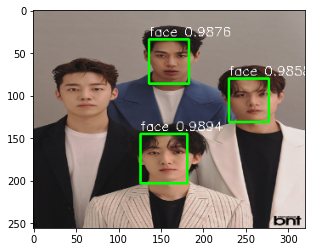

In [57]:
filepath = os.path.join(PROJECT_PATH, 'checkpoints', 'weights_epoch_010.h5')
model.save_weights(filepath)

TEST_IMAGE_PATH = os.path.join(PROJECT_PATH, 'image.png')

img_raw = cv2.imread(TEST_IMAGE_PATH)
img_raw = cv2.resize(img_raw, (IMAGE_WIDTH, IMAGE_HEIGHT))
img = np.float32(img_raw.copy())

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img, pad_params = pad_input_image(img, max_steps=max(BOX_STEPS))
img = img / 255.0

boxes = default_box()
boxes = tf.cast(boxes, tf.float32)

predictions = model.predict(img[np.newaxis, ...])

pred_boxes, labels, scores = parse_predict(predictions, boxes)
pred_boxes = recover_pad(pred_boxes, pad_params)

for box_index in range(len(pred_boxes)):
    draw_box_on_face(img_raw, pred_boxes, labels, scores, box_index, IMAGE_LABELS)

plt.imshow(cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB))
plt.show()

어떤가요? 결과가 잘 나오시나요? 하이퍼파라미터를 약간 조정하고 학습을 조금 더 돌려서 저는 이런 결과를 얻었습니다.

![](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-11-P-05.png)

|epoch 30|epoch70|
|:---:|:---:|
|![](https://velog.velcdn.com/images/seona056/post/850ff191-83a7-416d-944f-9092fb71f2d7/image.png)|![](https://velog.velcdn.com/images/seona056/post/d63ff46a-cfaa-4853-be0c-73152fbff0de/image.png)|

<br>

- epoch 30일때는 2명 밖에 못 찾았는데, epoch 70일 때는 3명의 얼굴을 찾았다.

# 14-10. 프로젝트 : 스티커를 붙여주자

![](https://d3s0tskafalll9.cloudfront.net/media/images/GC-11-P-07.max-800x600.png)

드디어 딥러닝 모델을 이용해 우리의 스티커앱을 개선해서, 이미지 속 다수의 사람에게 스티커를 붙여줄 수 있게 되었습니다. 위 그림의 예시처럼 말이죠.

여러분들도 여러분들의 작품을 통해 이 작업을 본격적으로 수행해 봅시다. 첫 번째 스텝에서 제공해 드린 프로젝트 코드를 적극적으로 활용하셔도 좋습니다.

<br>

**라이브러리 버전 확인**

사용할 주요 라이브러리 버전을 확인해봅니다.

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

print(tf.__version__)
print(np.__version__)
print(cv2.__version__)

# Step 1. 스티커 구하기 혹은 만들기

왕관 또는 고양이 수염 등을 구하거나 혹은 다양한 아이디어의 스티커를 만들어 볼 수 있을 것입니다.

# Step 2. SSD 모델을 통해 얼굴 bounding box 찾기

우리는 실습 코드를 진행하며 필요한 모델을 이미 생성해 왔을 것입니다. 잘 훈련된 해당 모델을 통해 적절한 얼굴 bounding box를 찾아내 봅시다. `inference.py` 코드를 적극적으로 참고해 보시기를 권합니다.

# Step 3. dlib 을 이용한 landmark 찾기 (선택사항)

붙이려는 이미지에 따라 face landmark를 찾아야 할 수도 있습니다. 검출된 bounding box에 dlib을 적용해 face landmark를 찾을 수 있을 것입니다.<br>
dlib를 이용하려는 경우, `inference.py` 에서 `show_image` 메소드를 사용한 부분을 적절히 수정해야 가능할 것입니다.

# Step 4. 스티커 합성 사진 생성하기

여러분들이 선택한 인물사진에 스티커를 합성해 봅시다. 이미지에 너무 많은 사람 얼굴이 포함되어 있거나, 검출된 얼굴이 너무 작아서 스티커 합성이 어울리지 않으면 적당하지 않겠죠? 3~5명 정도의 얼굴이 포함된 적당한 사진을 선택해 주세요.

<br>

생성된 이미지를 프로젝트 코드와 함께 제출해 주세요~

<br>

그동안 수고 많으셨습니다!!!

# 회고

## 공부한 내용

## 루브릭 평가 지표를 맞추기 위해 시도한 것들

|평가문항|상세기준|
|:------|:---|
|1. multiface detection을 위한 widerface 데이터셋의 전처리가 적절히 진행되었다.|tfrecord 생성, augmentation, prior box 생성 등의 과정이 정상적으로 진행되었다.|
|2. SSD 모델이 안정적으로 학습되어 multiface detection이 가능해졌다.|inference를 통해 정확한 위치의 face bounding box를 detect한 결과이미지가 제출되었다.|
|3. 이미지 속 다수의 얼굴에 스티커가 적용되었다.|이미지 속 다수의 얼굴의 적절한 위치에 스티커가 적용된 결과이미지가 제출되었다.|